In [1]:
# SDSS DR16
# MaNGA data: md
# SDSS data: sd

"""

code reference
.union - https://wikidocs.net/1015
argsort - https://codetorial.net/tips_and_examples/numpy_argsort.html

"""

print("""
1. BPT diagram을 통해 AGN, Seyferts, LINERS 정의하기 
2. O[III] line strength를 통해 weak/strong AGN 정의
3. 논문에서 얘기한 property들을 비교 e.g., mass, morphology
""")


1. BPT diagram을 통해 AGN, Seyferts, LINERS 정의하기 
2. O[III] line strength를 통해 weak/strong AGN 정의
3. 논문에서 얘기한 property들을 비교 e.g., mass, morphology



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import WMAP9 as cosmo

In [3]:
md = np.genfromtxt('GU2_TP_MaNGA.csv', dtype='str', delimiter=',')
print(md[0])
mdtype = [((md[0][i]), '<f8') for i in range(len(md[0]))]
mdata0 = np.genfromtxt('GU2_TP_MaNGA.csv', dtype=mdtype, delimiter=',', skip_header=1)

# sd = np.genfromtxt('GU2_TP_SDSS.csv', dtype='str', delimiter=',')
# print(sd[0])
# sdtype = [((sd[0][i]), '<f8') for i in range(len(sd[0]))]
# sdata0 = np.genfromtxt('GU2_TP_SDSS.csv', dtype=sdtype, delimiter=',', skip_header=1)

['mangaid' 'objra' 'objdec' 'z' 'emline_sflux_cen_oiii_5008'
 'emline_sflux_1re_oiii_5008' 'emline_sflux_tot_oiii_5008'
 'emline_sflux_cen_nii_6549' 'emline_sflux_1re_nii_6549'
 'emline_sflux_tot_nii_6549' 'emline_sflux_cen_sii_6718'
 'emline_sflux_1re_sii_6718' 'emline_sflux_tot_sii_6718'
 'emline_sflux_cen_sii_6732' 'emline_sflux_1re_sii_6732'
 'emline_sflux_tot_sii_6732' 'emline_sflux_cen_oi_6302'
 'emline_sflux_1re_oi_6302' 'emline_sflux_tot_oi_6302'
 'emline_sflux_cen_ha_6564' 'emline_sflux_1re_ha_6564'
 'emline_sflux_tot_ha_6564' 'emline_sflux_cen_hb_4862'
 'emline_sflux_1re_hb_4862' 'emline_sflux_tot_hb_4862'
 'emline_sflux_cen_hdel_4102' 'emline_sflux_1re_hdel_4102'
 'emline_sflux_tot_hdel_4102']


In [4]:
# Cutting
mcri0 = mdata0['objra'] > 0
mcri1 = mdata0['z'] > 0

mcri_ha = np.isnan(mdata0['emline_sflux_cen_ha_6564'])
mcri_hb = np.isnan(mdata0['emline_sflux_cen_hb_4862'])
mcri_oiii = np.isnan(mdata0['emline_sflux_cen_oiii_5008'])
mcri_nii = np.isnan(mdata0['emline_sflux_cen_nii_6549'])
mcri_sii18 = np.isnan(mdata0['emline_sflux_cen_sii_6718'])
mcri_sii32 = np.isnan(mdata0['emline_sflux_cen_sii_6732'])
mcri_oi = np.isnan(mdata0['emline_sflux_cen_oi_6302'])
mcri_hd = np.isnan(mdata0['emline_sflux_cen_hdel_4102'])
mcri2 = ~mcri_ha & ~mcri_hb & ~mcri_oiii & ~mcri_nii & ~mcri_sii18 & ~mcri_sii32 & ~mcri_oi & ~mcri_hd

mcri_ha0 = np.where(mdata0['emline_sflux_cen_ha_6564'] == 0)[0]
mcri_hb0 = np.where(mdata0['emline_sflux_cen_hb_4862'] == 0)[0]
zero_list = sorted(list(set(mcri_ha0).union(set(mcri_hb0))))
mcri3 = [True] * len(mdata0['z'])
for i in range(len(zero_list)):
    mcri3[zero_list[i]] = False

# Total
mcri = mcri0 & mcri1 & mcri2 & mcri3
mdata = mdata0[mcri]

print(len(mdata0), len(mdata0[mcri0]), len(mdata0[mcri1]), len(mdata0[mcri2]), len(mdata0[mcri3]), len(mdata))

8514 8514 8456 8514 8492 8456


In [5]:
# # Cutting
# scri0 = sdata0['ra'] > 0
# scri1 = sdata0['z'] > 0
# scri_ha = np.isnan(sdata0['h_alpha_cont'])
# scri_hb = np.isnan(sdata0['h_beta_cont'])
# scri_ha0 = np.where(sdata0['h_alpha_cont'] == 0)[0]
# scri_hb0 = np.where(sdata0['h_beta_cont'] == 0)[0]
# scri_0 = np.array([True] * len(sdata0))
# for i in range(len(scri_ha0)):
#     scri_0[scri_ha0[i]] == False
# for i in range(len(scri_hb0)):
#     scri_0[scri_hb0[i]] == False

# scri = scri0 & scri1 & ~scri_ha & ~scri_hb & scri_0
# sdata = sdata0[scri]

In [6]:
# print(len(sdata0['h_beta_cont'][scri]))
# print(len(np.where(sdata0['h_beta_cont'][scri] == 0)[0]))
# print(len(np.where(sdata0['h_beta_cont'][scri_ha0] == 0)[0]))

In [7]:
# Select cen flux
moiii = mdata['emline_sflux_cen_oiii_5008']
mnii = mdata['emline_sflux_cen_nii_6549']
msii18 = mdata['emline_sflux_cen_sii_6718']
msii32 = mdata['emline_sflux_cen_sii_6732']
moi = mdata['emline_sflux_cen_oi_6302']
mha = mdata['emline_sflux_cen_ha_6564']
mhb = mdata['emline_sflux_cen_hb_4862']
mhd = mdata['emline_sflux_cen_hdel_4102']

In [8]:
# # cen flux
# soiii = sdata['oiii_5007_cont']
# snii = sdata['nii_6548_cont']
# ssii17 = sdata['sii_6717_cont']
# ssii31 = sdata['sii_6731_cont']
# soi = sdata['oi_6300_cont']
# sha = sdata['h_alpha_cont']
# shb = sdata['h_beta_cont']
# shd = sdata['h_delta_cont']

In [9]:
# Cut invalid calculator
cri_mon1 = moiii / mhb > 0
cri_mon2 = mnii / mha > 0
cri_mon = cri_mon1 & cri_mon2
cri_mos1 = moiii / mhb > 0
cri_mos2 = msii18 / mha > 0
cri_mos3 = msii32 / mha > 0
cri_mos = cri_mos1 & cri_mos2 & cri_mos3
cri_moo1 = moiii / mhb > 0
cri_moo2 = moi / mha > 0
cri_moo = cri_moo1 & cri_moo2

In [10]:
# # Cut nan
# cri_soiii = np.isnan(soiii)
# cri_snii = np.isnan(snii)
# cri_ssii17 = np.isnan(ssii17)
# cri_ssii31 = np.isnan(ssii31)
# cri_soi = np.isnan(soi)
# cri_shd = np.isnan(shd)

# cri_son1 = soiii / shb > 0
# cri_son2 = snii / sha > 0
# cri_son = cri_son1 & cri_son2
# cri_sos1 = soiii / shb > 0
# cri_sos2 = ssii17 / sha > 0
# cri_sos3 = ssii31 / sha > 0
# cri_sos = cri_sos1 & cri_sos2 & cri_sos3
# cri_soo1 = soiii / shb > 0
# cri_soo2 = soi / sha > 0
# cri_soo = cri_soo1 & cri_soo2

In [11]:
# cri_moiii_nii = cri_moiii & cri_mnii & cri_mha & cri_mhb
# cri_moiii_sii = cri_moiii & cri_msii18 & cri_msii32 & cri_mha & cri_mhb
# cri_moiii_oi = cri_moiii & cri_moi & cri_mha & cri_mhb

In [12]:
# cri_soiii_nii = cri_soiii & cri_snii & cri_sha & cri_shb
# cri_soiii_sii = cri_soiii & cri_ssii17 & cri_ssii31 & cri_sha & cri_shb
# cri_soiii_oi = cri_soiii & cri_soi & cri_sha & cri_shb

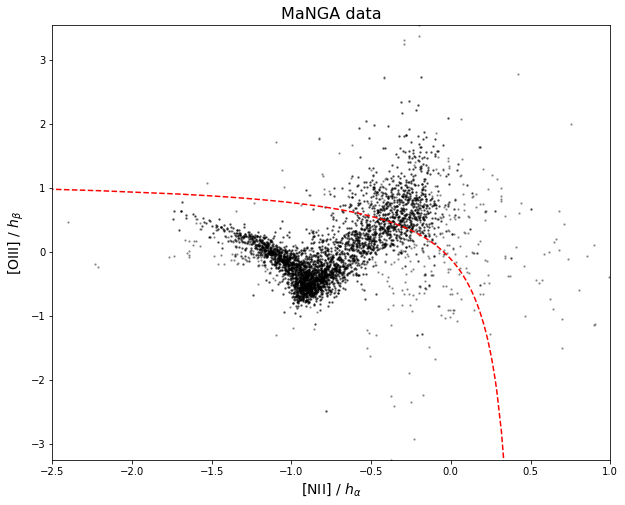

In [26]:
# BPT w. oiii_hb & nii_ha
moiii_hb = np.log10(moiii[cri_mon] / mhb[cri_mon])
mnii_ha = np.log10(mnii[cri_mon] / mha[cri_mon])

mxline_nii_ha = mnii_ha[mnii_ha < 0.47]
myline_nii_ha = 0.61 / (mnii_ha[mnii_ha < 0.47] - 0.47) + 1.19
s = mxline_nii_ha.argsort()
mx_nii_ha = mxline_nii_ha[s]
my_nii_ha = myline_nii_ha[s]

plt.figure(figsize=(10,8))

plt.scatter(mnii_ha, moiii_hb, c='k', s=2,alpha=0.3)
plt.plot(mx_nii_ha, my_nii_ha, 'r--')
plt.ylim(min(moiii_hb), max(moiii_hb))
plt.xlim(-2.5,1.0)

plt.xlabel(r'[NII] / $h_{\alpha}$',fontsize=14)
plt.ylabel(r'[OIII] / $h_{\beta}$',fontsize=14)
plt.title('MaNGA data',fontsize=16)
plt.show()

# soiii_hb = np.log10(soiii[~cri_soiii_nii] / shb[~cri_soiii_nii])
# snii_ha = np.log10(snii[~cri_soiii_nii] / sha[~cri_soiii_nii])
# sline_nii_ha = 0.61 / (snii_ha[snii_ha < 0.47] - 0.47) + 1.19

# plt.figure(figsize=(5,5))
# plt.scatter(snii_ha, soiii_hb, c='k', s=1)
# plt.scatter(snii_ha[snii_ha < 0.47], sline_nii_ha, c='r')
# plt.ylim(min(soiii_hb), max(soiii_hb))

# plt.xlabel('[NII]/h$_\alpha$')
# plt.ylabel('[OIII]/h$_\beta$')
# plt.title('SDSS data')
# plt.show()

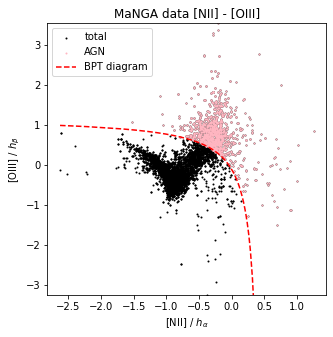

In [14]:
# above line
# justify AGN, Seyferts, LINERS
mnii_ha_agn = []
moiii_hb_agn = []
for i in range(len(mnii_ha)):
    if moiii_hb[i] > 0.61 / (mnii_ha[i] - 0.47) + 1.19 or mnii_ha[i] > 0.47:
        mnii_ha_agn.append(mnii_ha[i])
        moiii_hb_agn.append(moiii_hb[i])

plt.figure(figsize=(5,5))
plt.scatter(mnii_ha, moiii_hb, c='k', s=1, label='total')
plt.scatter(mnii_ha_agn, moiii_hb_agn, c='lightpink', s=1, label='AGN')
plt.plot(mx_nii_ha, my_nii_ha, 'r--', label='BPT diagram')

plt.ylim(min(moiii_hb), max(moiii_hb))
plt.xlabel(r'[NII] / $h_{\alpha}$')
plt.ylabel(r'[OIII] / $h_{\beta}$')
plt.title('MaNGA data [NII] - [OIII]')
plt.legend()
plt.show()

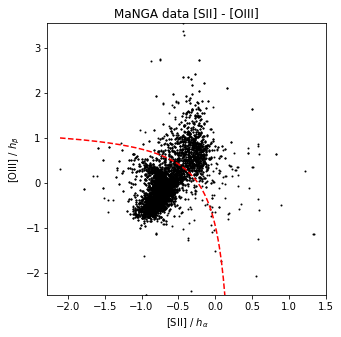

In [15]:
# # BPT w. oiii_hb & sii_ha
# oiii_hb = np.log10(oiii / hb)
# sii_ha = (np.log10(sii18 / ha) + np.log10(sii32 / ha)) / 2
# line_sii_ha = 0.72 / (sii_ha[sii_ha < 0.32] - 0.32) + 1.30

# plt.figure(figsize=(5,5))
# plt.scatter(sii_ha, oiii_hb, c='k', s=1)
# plt.scatter(sii_ha[sii_ha < 0.32], line_sii_ha, c='r')
# plt.ylim(min(sii_ha), max(sii_ha))
# plt.show()


# BPT w. oiii_hb & sii_ha
moiii_hb = np.log10(moiii[cri_mos] / mhb[cri_mos])
msii_ha = (np.log10(msii18[cri_mos] / mha[cri_mos]) + np.log10(msii32[cri_mos] / mha[cri_mos])) / 2

mxline_sii_ha = msii_ha[msii_ha < 0.32]
myline_sii_ha = 0.72 / (msii_ha[msii_ha < 0.32] - 0.32) + 1.30
s = mxline_sii_ha.argsort()
mx_sii_ha = mxline_sii_ha[s]
my_sii_ha = myline_sii_ha[s]

plt.figure(figsize=(5,5))
plt.scatter(msii_ha, moiii_hb, c='k', s=1)
plt.plot(mx_sii_ha, my_sii_ha, 'r--')
plt.ylim(min(moiii_hb), max(moiii_hb))

plt.xlabel(r'[SII] / $h_{\alpha}$')
plt.ylabel(r'[OIII] / $h_{\beta}$')
plt.title('MaNGA data [SII] - [OIII]')
plt.show()

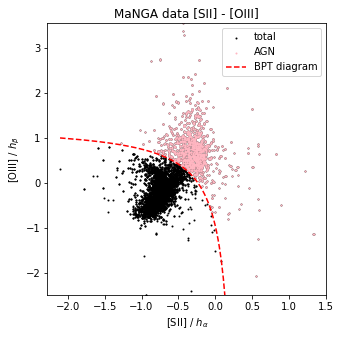

In [16]:
# above line
# justify AGN, Seyferts, LINERS
msii_ha_agn = []
moiii_hb_agn = []
for i in range(len(msii_ha)):
    if moiii_hb[i] > 0.72 / (msii_ha[i] - 0.32) + 1.30 or msii_ha[i] > 0.32:
        msii_ha_agn.append(msii_ha[i])
        moiii_hb_agn.append(moiii_hb[i])

plt.figure(figsize=(5,5))
plt.scatter(msii_ha, moiii_hb, c='k', s=1, label='total')
plt.scatter(msii_ha_agn, moiii_hb_agn, c='lightpink', s=1, label='AGN')
plt.plot(mx_sii_ha, my_sii_ha, 'r--', label='BPT diagram')
plt.ylim(min(moiii_hb), max(moiii_hb))

plt.xlabel(r'[SII] / $h_{\alpha}$')
plt.ylabel(r'[OIII] / $h_{\beta}$')
plt.title('MaNGA data [SII] - [OIII]')
plt.legend()
plt.show()

In [17]:
# # BPT w. oiii_hb & sii_ha
# oiii_hb = np.log10(oiii / hb)
# sii_ha2 = np.log10(sii18 / ha) + np.log10(sii32 / ha)
# line_sii_ha2 = 0.72 / (sii_ha2[sii_ha2 < 0.32] - 0.32) + 1.30

# plt.figure(figsize=(5,5))
# plt.scatter(sii_ha2, oiii_hb, c='k', s=1)
# plt.scatter(sii_ha2[sii_ha2 < 0.32], line_sii_ha2, c='r')
# plt.ylim(min(sii_ha2), max(sii_ha2))
# plt.show()

In [18]:
# x=np.linspace(-4,-0.591,1000)
# def line(x):
#     return 0.73/(x+0.59)+1.33

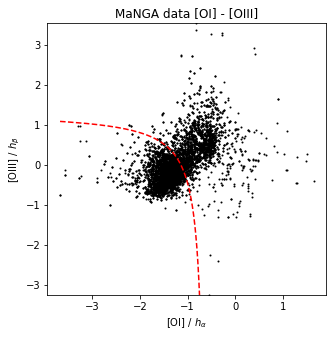

In [19]:
# # BPT w. oiii_hb & oi_ha
# oiii_hb = np.log10(oiii / hb)
# oi_ha = np.log10(oi / ha)
# line_oi_ha = 0.73 / (oi_ha[oi_ha < -0.59] + 0.59) + 1.33

# plt.figure(figsize=(5,5))
# plt.scatter(oi_ha, oiii_hb, c='k', s=1)
# # plt.scatter(oi_ha[oi_ha < -0.59], line_oi_ha, c='r')
# plt.plot(x, line(x),c='r',lw=1)
# plt.ylim(min(oi_ha), max(oi_ha))
# plt.ylim(-2,2)
# plt.xlim(-3,1)
# plt.show()

moiii_hb = np.log10(moiii[cri_moo] / mhb[cri_moo])
moi_ha = np.log10(moi[cri_moo] / mha[cri_moo])

mxline_oi_ha = moi_ha[moi_ha < -0.59]
myline_oi_ha = 0.73 / (moi_ha[moi_ha < -0.59] + 0.59) + 1.33
s = mxline_oi_ha.argsort()
mx_oi_ha = mxline_oi_ha[s]
my_oi_ha = myline_oi_ha[s]

plt.figure(figsize=(5,5))
plt.scatter(moi_ha, moiii_hb, c='k', s=1)
plt.plot(mx_oi_ha, my_oi_ha, 'r--')
plt.ylim(min(moiii_hb), max(moiii_hb))

plt.xlabel(r'[OI] / $h_{\alpha}$')
plt.ylabel(r'[OIII] / $h_{\beta}$')
plt.title('MaNGA data [OI] - [OIII]')
plt.show()

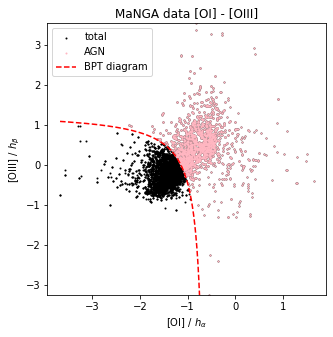

In [20]:
# above line
# justify AGN, Seyferts, LINERS
moi_ha_agn = []
moiii_hb_agn = []
for i in range(len(moi_ha)):
    if moiii_hb[i] > 0.73 / (moi_ha[i] + 0.59) + 1.33 or moi_ha[i] > -0.59:
        moi_ha_agn.append(moi_ha[i])
        moiii_hb_agn.append(moiii_hb[i])

plt.figure(figsize=(5,5))
plt.scatter(moi_ha, moiii_hb, c='k', s=1, label='total')
plt.scatter(moi_ha_agn, moiii_hb_agn, c='lightpink', s=1, label='AGN')
plt.plot(mx_oi_ha, my_oi_ha, 'r--', label='BPT diagram')
plt.ylim(min(moiii_hb), max(moiii_hb))

plt.xlabel(r'[OI] / $h_{\alpha}$')
plt.ylabel(r'[OIII] / $h_{\beta}$')
plt.title('MaNGA data [OI] - [OIII]')
plt.legend()
plt.show()